In [28]:
import numpy as np
import csv
from datetime import datetime
import pandas as pd

import matplotlib
matplotlib.rcParams.update({'font.size': 22})
matplotlib.rcParams["mathtext.default"] = 'regular' #enable \mathcal{S}

import matplotlib.pyplot as plt
import numpy.linalg as la
import scipy.stats as sp

class ecosystem:

    def __init__(self, 
                GAMMA = None,
                D_DIMENSION = 5, 
                P_NORM = 1, 
                NOISE = "normal", 
                MEAN = 0,
                SIGMA = 0.1,
                K_SPECIES_MAX = 100,
                ABUNDANCE_SPAWN = 0.01,  #Abundance after speciation event, change to something else
                ABUNDANCE_DEATH = 0.001, #Abundance below threshold --> species extinct.
                DEATH_RATE = 0.1,
                ALPHA = 0.05,
                BETA = 0.01,
                DT_TIMESCALE = 0.001,
                MEAN_INTERARRIVAL_TIME = 20.0, #Average time between speciation events
                SEED = None,
                WITH_RUNOUT = False, 
                RUNOUT_SCALING = 100, 
                MONOD = False, 
                MONOD_HALF_VELOCITY = None, 
                MONOD_ALPHAMAX = None,
                MONOD_BETAMAX = None,
                save_every = 10,
                result_folder = "results"
                ):

        self.GAMMA = GAMMA
        self.D_DIMENSION = D_DIMENSION
        self.P_NORM = P_NORM
        self.NOISE = NOISE
        self.MEAN = MEAN
        self.SIGMA = SIGMA
        self.K_SPECIES_MAX = K_SPECIES_MAX
        self.ABUNDANCE_SPAWN = ABUNDANCE_SPAWN
        self.ABUNDANCE_DEATH = ABUNDANCE_DEATH
        self.DEATH_RATE = DEATH_RATE
        self.ALPHA = ALPHA
        self.BETA = BETA
        self.DT_TIMESCALE = DT_TIMESCALE
        self.MEAN_INTERARRIVAL_TIME = MEAN_INTERARRIVAL_TIME
        self.SEED = SEED
        self.WITH_RUNOUT = WITH_RUNOUT
        self.RUNOUT_SCALING = RUNOUT_SCALING
        self.MONOD = MONOD
        self.MONOD_HALF_VELOCITY = MONOD_HALF_VELOCITY
        self.MONOD_ALPHAMAX = MONOD_ALPHAMAX
        self.MONOD_BETAMAX = MONOD_BETAMAX
        self.save_every = save_every
        self.result_folder = result_folder
          
        self.time = 0
        self.RNG = np.random.default_rng(seed = self.SEED)
        self.strategies = np.empty((K_SPECIES_MAX, D_DIMENSION))
        first_strategy = self.RNG.uniform(size=D_DIMENSION)
        self.strategies[0] = first_strategy/la.norm(first_strategy, ord=P_NORM) #vector containing the strategy vectors
        self.abundances = np.empty(K_SPECIES_MAX)
        self.abundances[0] = ABUNDANCE_SPAWN
        self.abundances[1:] = np.nan
        self.resources = np.ones(D_DIMENSION)  #vector containing resource abundances, maybe this is too much for initialization

        self.current_event = 1 # ID of where new species are put into system
        self.speciation_events = np.zeros(K_SPECIES_MAX)
        self.alive = np.zeros(K_SPECIES_MAX, dtype=int) #1 if species at ID is alive, 0 if it's not.
        self.alive[0] = 1
        self.lineage = np.zeros(K_SPECIES_MAX, dtype=int)
        self.start = datetime.now().strftime("%d%m_%H%M%S")
        self.results_csv = result_folder+"/{}_results.csv".format(self.start)
        
        if GAMMA is None:
            GAMMA = self.RNG.exponential(size=D_DIMENSION)
            self.GAMMA = GAMMA/la.norm(GAMMA, ord=P_NORM)
        
        if len(GAMMA) != D_DIMENSION:
            raise ValueError(f"GAMMA needs to be of length {D_DIMENSION}.")

        if MONOD:
            self.ALPHA = None
            self.BETA = None

        '''initialize vectors that save results per strategy'''
        self.generalist = np.ones(D_DIMENSION) / la.norm(np.ones(D_DIMENSION), ord=P_NORM)
        self.dist_to_generalist = np.empty(K_SPECIES_MAX)
        self.dist_to_generalist[0] = np.sqrt(np.dot((self.strategies[0] - self.generalist), (self.strategies[0] - self.generalist)))
        self.diff_max_min = np.empty(K_SPECIES_MAX)
        self.diff_max_min[0] = np.max(self.strategies[0]) - np.min(self.strategies[0])
        self.dist_to_gamma = np.empty(K_SPECIES_MAX)
        self.dist_to_gamma[0] = np.sqrt(np.dot((self.strategies[0] - self.GAMMA), (self.strategies[0] - self.GAMMA)))
        self.skewness = np.empty(K_SPECIES_MAX)
        self.skewness[0] = sp.skew(self.strategies[0], bias=False)

        '''initialize counters for efficient storage of results'''
        self.STORAGE_SIZE = 1000
        self.STORAGE_COUNTER = 0
        
        self.RESULTS = np.ones((self.STORAGE_SIZE, 11))
        self.RESULTS[self.STORAGE_COUNTER, 0] = 0 #time
        self.RESULTS[self.STORAGE_COUNTER, 1] = self.dist_to_generalist[0]
        self.RESULTS[self.STORAGE_COUNTER, 2] = 0
        self.RESULTS[self.STORAGE_COUNTER, 3] = self.diff_max_min[0]
        self.RESULTS[self.STORAGE_COUNTER, 4] = 0
        self.RESULTS[self.STORAGE_COUNTER, 5] = self.dist_to_gamma[0]
        self.RESULTS[self.STORAGE_COUNTER, 6] = 0
        self.RESULTS[self.STORAGE_COUNTER, 7] = self.skewness[0]
        self.RESULTS[self.STORAGE_COUNTER, 8] = 0
        self.RESULTS[self.STORAGE_COUNTER, 9] = 1 #K
        self.RESULTS[self.STORAGE_COUNTER, 10] = self.ABUNDANCE_SPAWN #total biomass
        self.STORAGE_COUNTER += 1
        
        with open(self.result_folder+"/PARAMETER_SETTINGS.csv", 'a', newline='') as csvfile:
            testwriter = csv.writer(csvfile, delimiter=',')
            testwriter.writerow([self.start, self.GAMMA, self.D_DIMENSION, self.P_NORM, self.NOISE, self.MEAN, self.SIGMA, self.K_SPECIES_MAX, self.ABUNDANCE_SPAWN, self.ABUNDANCE_DEATH, self.DEATH_RATE, self.ALPHA, self.BETA, self.DT_TIMESCALE, self.MEAN_INTERARRIVAL_TIME, self.SEED, self.WITH_RUNOUT, self.RUNOUT_SCALING, self.MONOD, self.MONOD_HALF_VELOCITY, self.MONOD_ALPHAMAX, self.MONOD_BETAMAX, self.save_every])
        
        '''write header for csv result file'''
        with open(self.results_csv, 'a', newline='') as csvfile:
            testwriter = csv.writer(csvfile, delimiter=',')
            testwriter.writerow(["time"] + ["AVG_DIST_TO_GEN"] + ["VAR_DIST_TO_GEN"] + ["AVG_DIFF_MAX_MIN"] + ["VAR_DIFF_MAX_MIN"] + ["AVG_DIST_TO_GAMMA"] + ["VAR_DIST_TO_GAMMA"] + ["AVG_SKEWNESS"] + ["VAR_SKEWNESS"] + ["K"] + ["BIOMASS"])

    
    def update_system(self):
        '''Integrates system in between speciation events'''

        timestep = self.RNG.exponential(self.MEAN_INTERARRIVAL_TIME) 
        self.speciation_events[self.current_event] = self.time + timestep

        while self.time < self.speciation_events[self.current_event]:

            '''Empty storage array if full'''
            if self.STORAGE_COUNTER == self.STORAGE_SIZE:
                with open(self.results_csv, 'a', newline='') as csvfile:
                    testwriter = csv.writer(csvfile, delimiter=',')
                    testwriter.writerows(self.RESULTS)
                    self.STORAGE_COUNTER = 0

            '''update system'''   
            self.resources += (self.GAMMA - self.BETA * np.dot(np.array(self.abundances[:self.current_event]), np.array(self.strategies[:self.current_event]))) * self.DT_TIMESCALE
            self.abundances[:self.current_event] += (self.ALPHA * (np.dot(np.array(self.strategies[:self.current_event]), np.array(self.resources).T)) - self.DEATH_RATE * np.ones(len(self.strategies[:self.current_event]))) * np.array(self.abundances[:self.current_event]) * self.DT_TIMESCALE
            self.time += self.DT_TIMESCALE

            ''' set resources and abundances to 0 if needed '''
            for i, resource in enumerate(self.resources):
                if resource <= 0:
                    self.resources[i] = 0
            
            for i, abundance in enumerate(self.abundances):
                if abundance <= self.ABUNDANCE_DEATH:
                    self.abundances[i] = 0
                    self.alive[i] = 0

            '''save results every indicated timestep'''
            if round(self.time, int(round(np.log10(1/self.DT_TIMESCALE),0))) % self.save_every == 0:
                self.RESULTS[self.STORAGE_COUNTER, 0] = self.time #time
                self.RESULTS[self.STORAGE_COUNTER, 1] = np.mean(self.dist_to_generalist[:self.current_event], where=[bool(i) for i in self.alive[:self.current_event]])
                self.RESULTS[self.STORAGE_COUNTER, 2] = np.var(self.dist_to_generalist[:self.current_event], where=[bool(i) for i in self.alive[:self.current_event]])
                self.RESULTS[self.STORAGE_COUNTER, 3] = np.mean(self.diff_max_min[:self.current_event], where=[bool(i) for i in self.alive[:self.current_event]])
                self.RESULTS[self.STORAGE_COUNTER, 4] = np.var(self.diff_max_min[:self.current_event], where=[bool(i) for i in self.alive[:self.current_event]])
                self.RESULTS[self.STORAGE_COUNTER, 5] = np.mean(self.dist_to_gamma[:self.current_event], where=[bool(i) for i in self.alive[:self.current_event]])
                self.RESULTS[self.STORAGE_COUNTER, 6] = np.var(self.dist_to_gamma[:self.current_event], where=[bool(i) for i in self.alive[:self.current_event]])     
                self.RESULTS[self.STORAGE_COUNTER, 7] = np.mean(self.skewness[:self.current_event], where=[bool(i) for i in self.alive[:self.current_event]])
                self.RESULTS[self.STORAGE_COUNTER, 8] = np.var(self.skewness[:self.current_event], where=[bool(i) for i in self.alive[:self.current_event]])
                self.RESULTS[self.STORAGE_COUNTER, 9] = np.sum(self.alive)
                self.RESULTS[self.STORAGE_COUNTER, 10] = np.nansum(self.abundances)
                self.STORAGE_COUNTER += 1
                
        '''ensure that all results are included in the csv file'''
        with open(self.results_csv, 'a', newline='') as csvfile:
            testwriter = csv.writer(csvfile, delimiter=',')
            testwriter.writerows(self.RESULTS[:self.STORAGE_COUNTER, :])
            self.STORAGE_COUNTER = 0

    
    def runout_system(self, timestep):
        '''Add extra simulation time after all speciation events occured'''
        
        timestep = self.MEAN_INTERARRIVAL_TIME * self.RUNOUT_SCALING

        while self.time < self.speciation_events[-1] + timestep:

            '''Empty storage array if full'''
            if self.STORAGE_COUNTER == self.STORAGE_SIZE:
                with open(self.results_csv, 'a', newline='') as csvfile:
                    testwriter = csv.writer(csvfile, delimiter=',')
                    testwriter.writerows(self.RESULTS)
                    self.STORAGE_COUNTER = 0

            '''update system'''
            resource_update = (self.GAMMA - self.BETA * np.dot(np.array(self.abundances[:self.current_event]), np.array(self.strategies[:self.current_event]))) * self.DT_TIMESCALE            
            self.resources += resource_update
            abundance_update = (self.ALPHA * (np.dot(np.array(self.strategies[:self.current_event]), np.array(self.resources).T)) - self.DEATH_RATE * np.ones(len(self.strategies[:self.current_event]))) * np.array(self.abundances[:self.current_event]) * self.DT_TIMESCALE
            self.abundances[:self.current_event] += abundance_update
            self.time += self.DT_TIMESCALE

            ''' set resources and abundances to 0 if needed '''
            for i, resource in enumerate(self.resources):
                if resource <= 0:
                    self.resources[i] = 0
            
            for i, abundance in enumerate(self.abundances):
                if abundance <= self.ABUNDANCE_DEATH:
                    self.abundances[i] = 0
                    self.alive[i] = 0

            '''save results every indicated timestep'''
            if round(self.time, int(round(np.log10(1/self.DT_TIMESCALE),0))) % self.save_every == 0:
                self.RESULTS[self.STORAGE_COUNTER, 0] = self.time #time
                self.RESULTS[self.STORAGE_COUNTER, 1] = np.mean(self.dist_to_generalist[:self.current_event], where=[bool(i) for i in self.alive[:self.current_event]])
                self.RESULTS[self.STORAGE_COUNTER, 2] = np.var(self.dist_to_generalist[:self.current_event], where=[bool(i) for i in self.alive[:self.current_event]])
                self.RESULTS[self.STORAGE_COUNTER, 3] = np.mean(self.diff_max_min[:self.current_event], where=[bool(i) for i in self.alive[:self.current_event]])
                self.RESULTS[self.STORAGE_COUNTER, 4] = np.var(self.diff_max_min[:self.current_event], where=[bool(i) for i in self.alive[:self.current_event]])
                self.RESULTS[self.STORAGE_COUNTER, 5] = np.mean(self.dist_to_gamma[:self.current_event], where=[bool(i) for i in self.alive[:self.current_event]])
                self.RESULTS[self.STORAGE_COUNTER, 6] = np.var(self.dist_to_gamma[:self.current_event], where=[bool(i) for i in self.alive[:self.current_event]])     
                self.RESULTS[self.STORAGE_COUNTER, 7] = np.mean(self.skewness[:self.current_event], where=[bool(i) for i in self.alive[:self.current_event]])
                self.RESULTS[self.STORAGE_COUNTER, 8] = np.var(self.skewness[:self.current_event], where=[bool(i) for i in self.alive[:self.current_event]])
                self.RESULTS[self.STORAGE_COUNTER, 9] = np.sum(self.alive)
                self.RESULTS[self.STORAGE_COUNTER, 10] = np.nansum(self.abundances)
                self.STORAGE_COUNTER += 1
                
        '''ensure that all results are included in the csv file'''
        with open(self.results_csv, 'a', newline='') as csvfile:
            testwriter = csv.writer(csvfile, delimiter=',')
            testwriter.writerows(self.RESULTS[:self.STORAGE_COUNTER, :])
            self.STORAGE_COUNTER = 0


    def speciation_event(self):
        '''Adds specie to the ecosystem'''

        probabilities = self.abundances[:self.current_event] / np.sum(self.abundances[:self.current_event])
        ancestor_ID = self.RNG.choice(self.current_event, p=probabilities)

        if self.NOISE == "normal":
            self.strategies[self.current_event] = self.strategies[ancestor_ID] + self.RNG.normal(loc=self.MEAN, scale=self.SIGMA, size=self.D_DIMENSION)
            for i, strat in enumerate(self.strategies[self.current_event]):
                if strat < 0:
                    self.strategies[self.current_event][i] = 0
            self.strategies[self.current_event] = self.strategies[self.current_event] /la.norm(self.strategies[self.current_event], ord=self.P_NORM)

        elif self.NOISE == "laplace":
            self.strategies[self.current_event] = self.strategies[ancestor_ID] + self.RNG.laplace(loc=self.MEAN, scale=self.SIGMA, size=self.D_DIMENSION)
            for i, strat in enumerate(self.strategies[self.current_event]):
                if strat < 0:
                    self.strategies[self.current_event][i] = 0
            self.strategies[self.current_event] = self.strategies[self.current_event] /la.norm(self.strategies[self.current_event], ord=self.P_NORM)

        else:
            raise ValueError("Noise function not specified. Try 'normal' or 'laplace'.")
        
        self.alive[self.current_event] = 1
        self.lineage[self.current_event] = ancestor_ID
        self.abundances[self.current_event] = self.ABUNDANCE_SPAWN

        self.dist_to_generalist[self.current_event] = np.sqrt(np.dot((self.strategies[self.current_event] - self.generalist), (self.strategies[self.current_event] - self.generalist)))
        self.diff_max_min[self.current_event] = np.max(self.strategies[self.current_event]) - np.min(self.strategies[self.current_event])
        self.dist_to_gamma[self.current_event] = np.sqrt(np.dot((self.strategies[self.current_event] - self.GAMMA), (self.strategies[self.current_event] - self.GAMMA)))
        self.skewness[self.current_event] = sp.skew(self.strategies[self.current_event], bias=False)
        self.current_event += 1


    def run_sim(self):
        for _ in range(self.K_SPECIES_MAX-1):
            
            self.update_system()
            self.speciation_event()

        if self.WITH_RUNOUT:
            self.runout_system(self.RUNOUT_SCALING*self.MEAN_INTERARRIVAL_TIME)

        '''write strategies to file'''
        strategies_csv = self.result_folder+"/{}_strategies.csv".format(self.start)
        
        with open(strategies_csv, 'a', newline='') as csvfile:
            testwriter = csv.writer(csvfile, delimiter=',')
            testwriter.writerow(["ID"] + ["strat_res"+str(i) for i in range(self.D_DIMENSION)] + ["ancestor"] + ["alive_at_end"] + ["DIST_TO_GEN"]  + ["DIFF_MAX_MIN"]  + ["DIST_TO_GAMMA"] + ["SKEWNESS"])
            for ID, strategy in enumerate(self.strategies):
                testwriter.writerow([ID] + [strat for strat in strategy] + [self.lineage[ID]] + [bool(self.abundances[ID])] + [self.dist_to_generalist[ID]] + [self.diff_max_min[ID]] + [self.dist_to_gamma[ID]] + [self.skewness[ID]])

                           
    def show_plots(self, cutoff=0):
        '''show plot for resource and species abundance over time
        cutoff specifies the number of first timesteps to ignore
        
        function only exists in notebook version'''

        df = pd.read_csv(self.results_csv)
        
        plt.plot(df.time[cutoff:], df.AVG_DIST_TO_GEN[cutoff:], zorder=1, c="black")
        plt.errorbar(df.time[cutoff:], df.AVG_DIST_TO_GEN[cutoff:], yerr=np.sqrt(df.VAR_DIST_TO_GEN[cutoff:]), c="lightgrey", zorder=0)
        plt.xlabel("$t$")
        plt.ylabel("$\mathcal{S}_{gen}$")
        # ax = plt.gca()
        # ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
        plt.savefig(self.result_folder+"/{}_dist_to_gen.png".format(self.start))
        plt.show()

        plt.plot(df.time[cutoff:], df.AVG_DIFF_MAX_MIN[cutoff:], zorder=1, c="black")
        plt.errorbar(df.time[cutoff:], df.AVG_DIFF_MAX_MIN[cutoff:], yerr=np.sqrt(df.VAR_DIFF_MAX_MIN[cutoff:]), zorder=0, c="lightgrey")
        plt.xlabel("$t$")
        plt.ylabel("$\mathcal{S}_{diff}$")
        # ax = plt.gca()
        # ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
        plt.savefig(self.result_folder+"/{}_diff_min_max.png".format(self.start))
        plt.show()

        plt.plot(df.time[cutoff:], df.AVG_DIST_TO_GAMMA[cutoff:], zorder=1, c="black")
        plt.errorbar(df.time[cutoff:], df.AVG_DIST_TO_GAMMA[cutoff:], yerr=np.sqrt(df.VAR_DIST_TO_GAMMA[cutoff:]), zorder=0, c="lightgrey")
        plt.xlabel("$t$")
        plt.ylabel("$\mathcal{S}_{\gamma}$")
        ax = plt.gca()
        ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
        plt.savefig(self.result_folder+"/{}_dist_to_gamma.png".format(self.start))
        plt.show()

        plt.plot(df.time[cutoff:], df.AVG_DIST_TO_GAMMA[cutoff:], zorder=1, c="black")
        plt.errorbar(df.time[cutoff:], df.AVG_DIST_TO_GAMMA[cutoff:], yerr=np.sqrt(df.VAR_DIST_TO_GAMMA[cutoff:]), zorder=0, c="lightgrey")
        plt.xlabel("$t$")
        plt.ylabel("$\mathcal{S}_{skew}$")
        ax = plt.gca()
        ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
        plt.savefig(self.result_folder+"/{}_skew.png".format(self.start))
        plt.show()

        plt.plot(df.time[cutoff:], df.K[cutoff:], c="black")
        plt.xlabel("$t$")
        plt.ylabel("$K$")
        # ax = plt.gca()
        # ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
        plt.savefig(self.result_folder+"/{}_K.png".format(self.start))
        plt.show()

        plt.plot(df.time[cutoff:], df.BIOMASS[cutoff:], c="black")
        plt.xlabel("$t$")
        plt.ylabel("biomass")
        # ax = plt.gca()
        # ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
        plt.savefig(self.result_folder+"/{}_BIOMASS.png".format(self.start))
        plt.show()



In [29]:
MA_test = ecosystem(P_NORM=0.9, K_SPECIES_MAX=1000, MEAN_INTERARRIVAL_TIME=20, DT_TIMESCALE=1, save_every=10, result_folder="degree_specialisation", WITH_RUNOUT=True, RUNOUT_SCALING=100)
MA_test.run_sim()

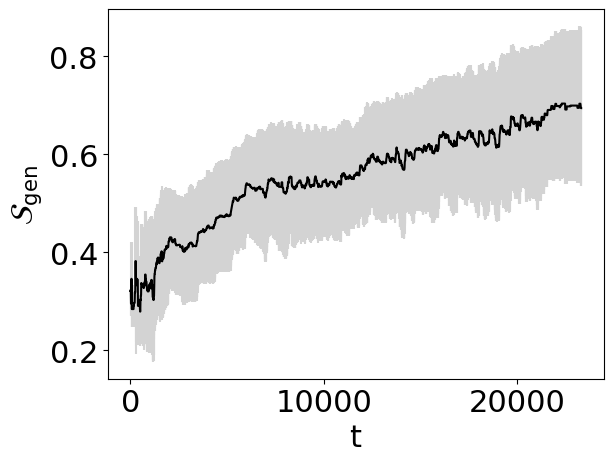

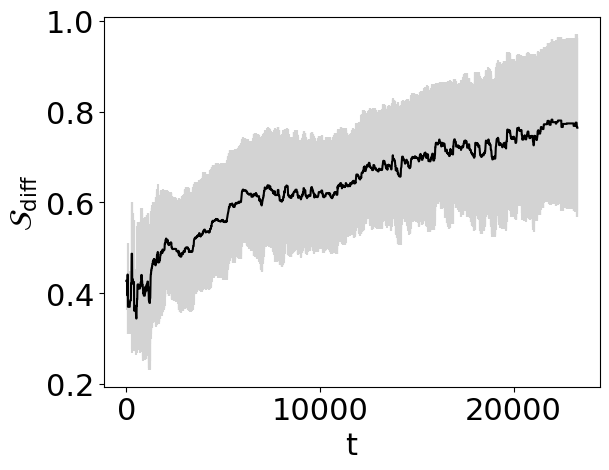

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


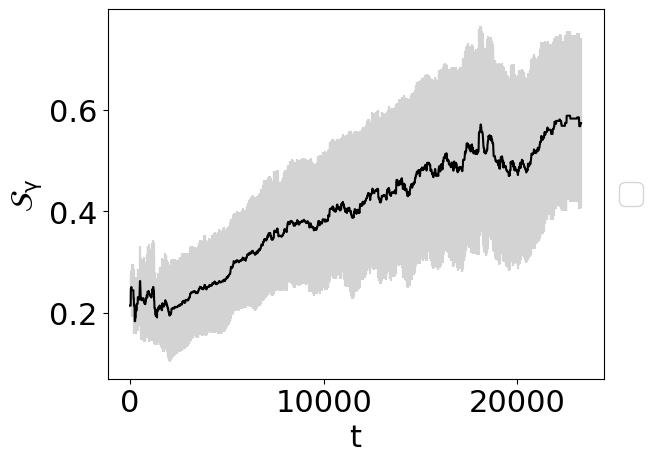

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


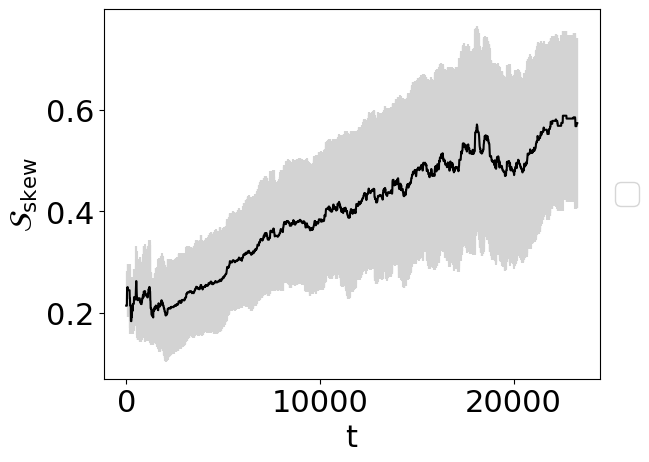

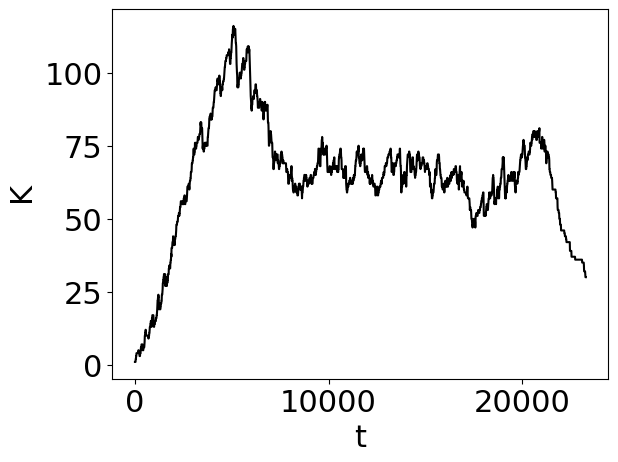

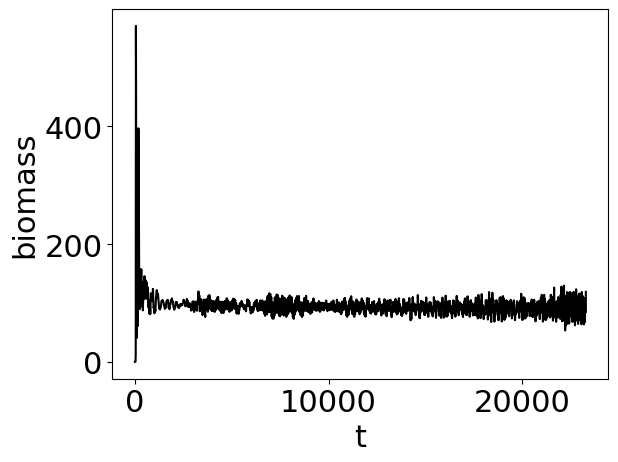

In [30]:
MA_test.show_plots()

In [37]:
MA_test_large = ecosystem(D_DIMENSION=100, K_SPECIES_MAX=10000, DT_TIMESCALE=1, MEAN_INTERARRIVAL_TIME=15, P_NORM=2)
MA_test_large.run_sim()

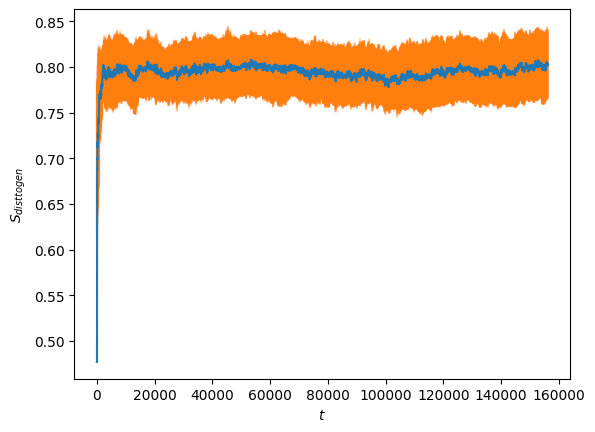

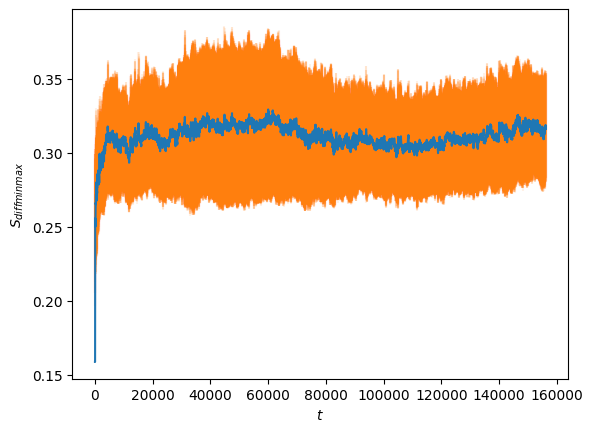

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


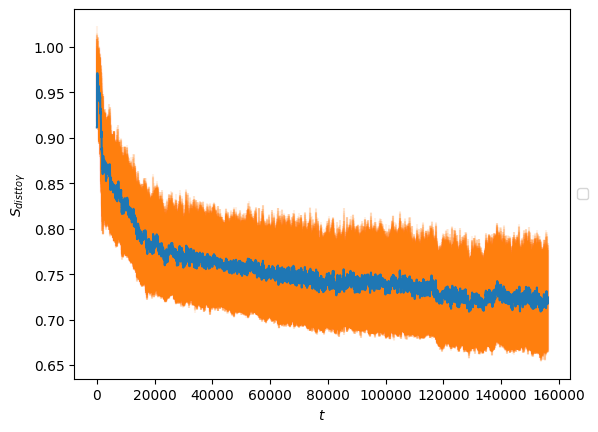

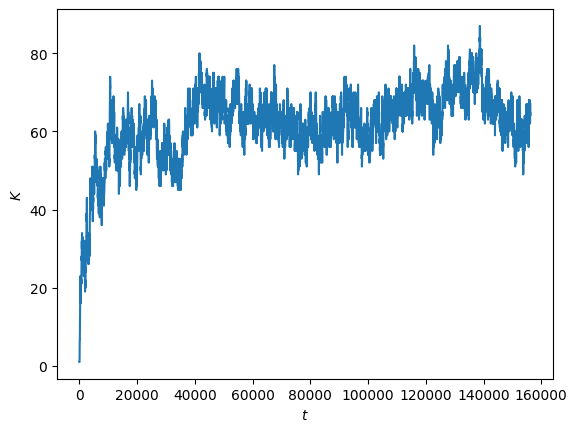

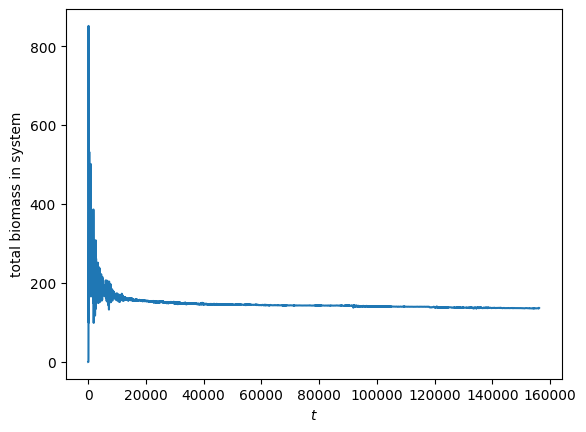

In [38]:
MA_test_large.show_plots()

In [6]:
""" DO NOT DELETE """

# I repeat

"""
DO
NOT
DELETE
"""

# with open("degree_specialisation/PARAMETER_SETTINGS.csv", 'w', newline='') as csvfile:
#     testwriter = csv.writer(csvfile, delimiter=',')
#     testwriter.writerow(["ID", "GAMMA", "D_DIMENSION", "P_NORM", "NOISE", "MEAN", "SIGMA", "K_SPECIES_MAX", "ABUNDANCE_SPAWN", "ABUNDANCE_DEATH", "DEATH_RATE", "ALPHA", "BETA", "DT_TIMESCALE", "MEAN_INTERARRIVAL_TIME", "SEED", "WITH_RUNOUT", "RUNOUT_SCALING", "MONOD", "MONOD_HALF_VELOCITY", "MONOD_ALPHAMAX", "MONOD_BETAMAX", "save_every"])

print("Thank you!")

Thank you!


In [17]:
MA_test = ecosystem(P_NORM=0.5, K_SPECIES_MAX=1000, MEAN_INTERARRIVAL_TIME=10, DEATH_RATE=0.01, DT_TIMESCALE=0.1, save_every=10, result_folder="degree_specialisation", WITH_RUNOUT=True, RUNOUT_SCALING=1000)
MA_test.run_sim()

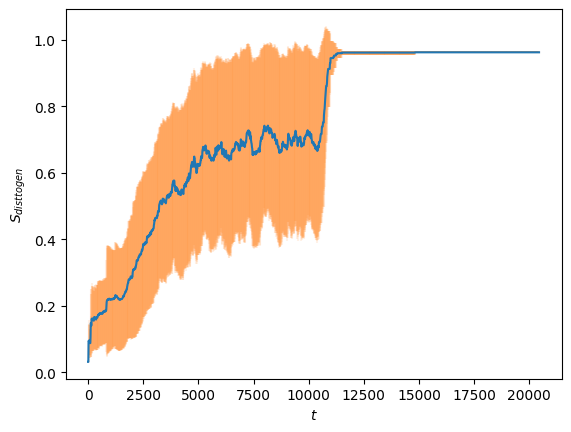

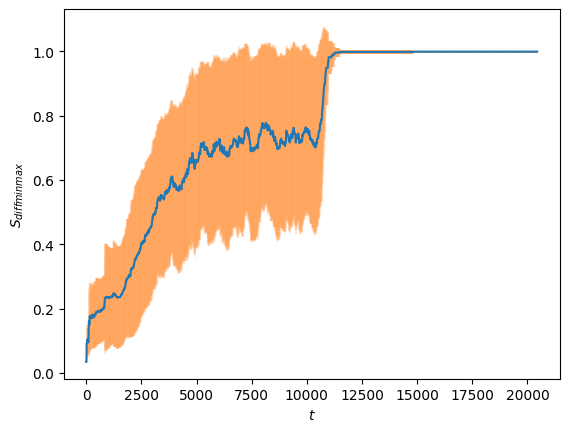

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


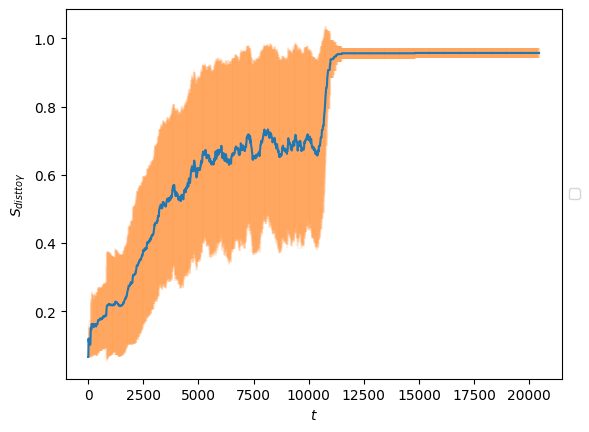

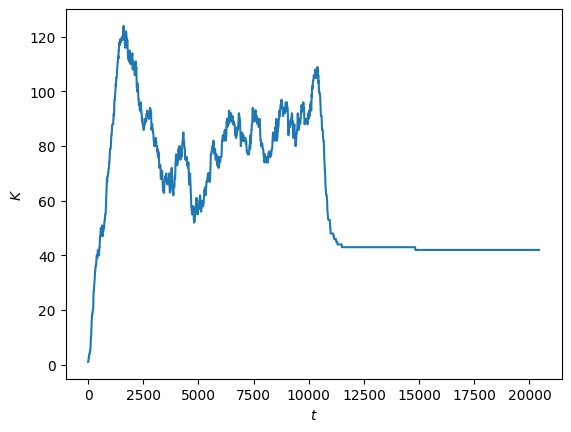

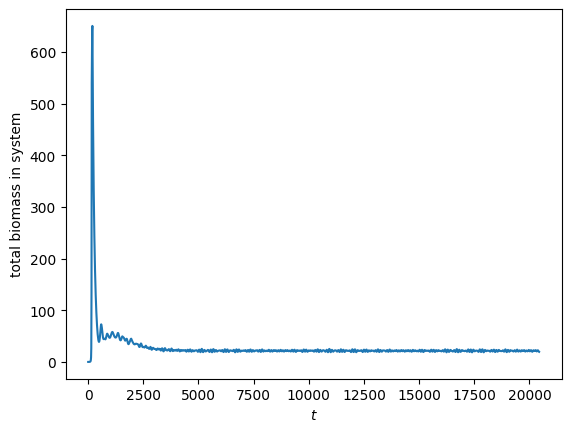

In [18]:
MA_test.show_plots()

In [21]:
MA_test = ecosystem(P_NORM=0.5, K_SPECIES_MAX=1000, MEAN_INTERARRIVAL_TIME=10, DEATH_RATE=0.01, DT_TIMESCALE=0.1, save_every=10, result_folder="degree_specialisation", WITH_RUNOUT=True, RUNOUT_SCALING=1000, SIGMA = 0.01)
MA_test.run_sim()

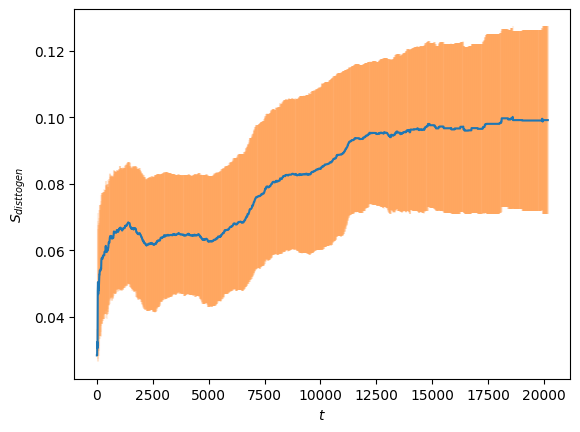

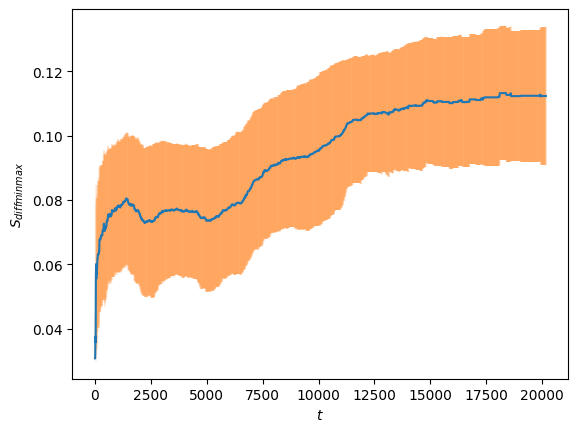

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


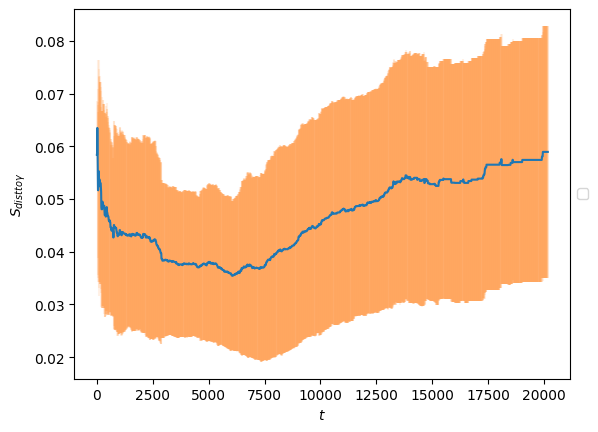

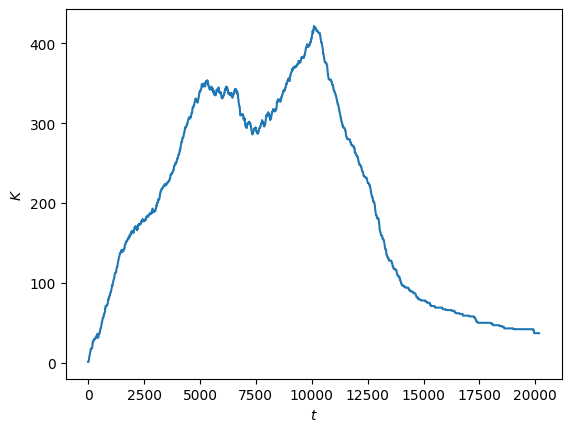

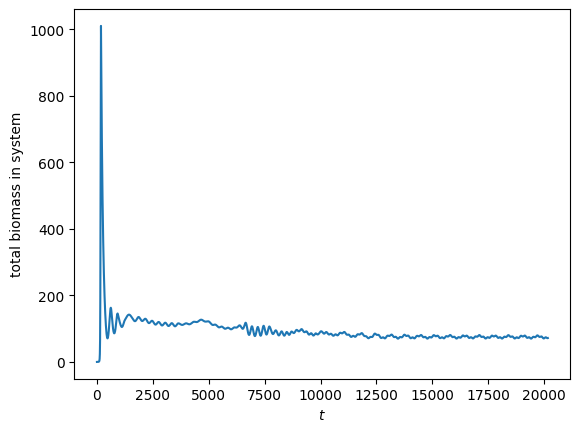

In [20]:
MA_test.show_plots()